In [4]:
import pickle
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
loss_func = torch.nn.MSELoss()
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import time
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
from tqdm import tqdm
from torch.nn import LeakyReLU
leaky = LeakyReLU(0.0)

def calculate_score(x, users, aspects):
    niubi = []
    # users: 128 * 8
    first = x.index[0]
    val_base = x[first]
    actor_base = torch.LongTensor(val_base)
    actors_base = aspects(actor_base)  # 3 * 8
    pre_rating = torch.mm(actors_base, users[first].unsqueeze(1))
    niubi.append(pre_rating)
    pre_rating = pre_rating / pre_rating.shape[0]
    pre_rating = pre_rating.sum(0)
    for i in x.index[1:]:
        val = x[i]
        actor = torch.LongTensor(val)
        actors = aspects(actor)
        pre_ra = torch.mm(actors, users[i].unsqueeze(1))
        niubi.append(pre_ra)
        actors_f = pre_ra / pre_ra.shape[0]
        actors_f = actors_f.sum(0)
        pre_rating = torch.cat((pre_rating, actors_f))
    return pre_rating, niubi


class aspect_augumentation(nn.Module):
    def __init__(self, n_users, n_entity, n_rk, n_factors):
        super(aspect_augumentation, self).__init__()
        self.n_users = n_users
        self.n_entity = n_entity
        self.n_rk = n_rk
        self.n_factors = n_factors
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.entity_factors = torch.nn.Embedding(n_entity, n_factors)
        self.relation_k = torch.nn.Embedding(n_factors, n_rk)


    def forward(self, user_id, actors_id, directors_id, genres_id):
        '''
        user_factors: n_users * 64
        entity_factors: n_entity * 64
        relation_k: 64 * 3
        '''

        users = self.user_factors(user_id)  # 128 * 8
        aspects = self.entity_factors  # n_entity * 8
        users = F.dropout(users, p=rate, training=self.training)
        scores = torch.matmul(users, F.dropout(self.relation_k.weight, p=rate, training=self.training))  # 128 * 3
        scores = leaky(scores)
        m=torch.nn.Softmax(dim=1)  # 128 * 3
        scores=m(scores)  # 128 * 3

        '''
        Compute the importance of each aspects
        '''
        scores_actors=scores[:, 0] # 128,
        scores_directors=scores[:, 1] # 128,
        scores_genres=scores[:, 2] # 128,

        '''
        Compute the contribution of each aspects
        '''
        contribute_actors,niubi_act=calculate_score(
            actors_id, users,aspects)
        contribute_directors, niubi_dir=calculate_score(
            directors_id, users,aspects)
        contribute_genres, niubi_gen=calculate_score(
            genres_id, users, aspects)

        '''
        Compute the final predictions
        '''
        importance_sum=scores_actors + scores_directors + scores_genres
        prediction_sum=contribute_actors * scores_actors + contribute_directors * scores_directors + contribute_genres * scores_genres
        prediction=prediction_sum / importance_sum
        cnm = [niubi_act,niubi_dir,niubi_gen]

        return prediction, scores, contribute_actors, contribute_directors, contribute_genres,cnm

In [6]:
import json
trainset = pd.read_csv('ready_to_use/train.csv')
testset = pd.read_csv('ready_to_use/test.csv')
trainset['user_rating'] = (trainset['user_rating'] + 1) * 2 + 1
testset['user_rating'] = (testset['user_rating'] + 1) * 2 + 1
def traite_train_test(df):
    df['actors'] = df['actors'].apply(lambda x: json.loads(x))
    df['director'] = df['director'].apply(lambda x: json.loads(x))
    df['genre'] = df['genre'].apply(lambda x: json.loads(x))
    return df
trainset = traite_train_test(trainset)
testset = traite_train_test(testset)
hehe_test = trainset.copy()
df_empty = testset.copy()
df_empty['user_id'] = df_empty['user_id'].astype('int')
df_empty['user_rating'] = df_empty['user_rating'].astype('float')
df_empty['movie'] = df_empty['movie'].astype('int')
hehe_test.index = range(len(hehe_test))
df_empty.index = range(len(df_empty))

In [7]:
def binary_predictions(true_ratings, predicted_ratings):
    assert len(true_ratings) == len(predicted_ratings)
    binary_true_ratings = []
    binary_predicted_ratings = []

    for i in range(len(true_ratings)):
        if true_ratings[i] >= 3:
            binary_true_ratings.append(1)
        else:
            binary_true_ratings.append(0)

        if predicted_ratings[i] >= 3:
            binary_predicted_ratings.append(1)
        else:
            binary_predicted_ratings.append(0)

    return precision_score(binary_true_ratings, binary_predicted_ratings), recall_score(binary_true_ratings, binary_predicted_ratings), f1_score(binary_true_ratings, binary_predicted_ratings)

In [8]:
def arg_accuracy_int(ratings, predictions):
    ratings = ratings.cpu().detach().numpy()
    predictions = predictions.cpu().detach().numpy()
    total_nr = len(ratings)
    total_pred = 0
    for i in range(total_nr):
        (true_rating, pred_rating) = ratings[i], predictions[i]
        if round(pred_rating) >= int(true_rating)-1 and round(pred_rating) <= int(true_rating)+1:
            total_pred += 1

    return float(total_pred)/total_nr


def round_of_rating(number):
    return round(number * 2) / 2

In [9]:
def RMSE(data, model):
    num_example = len(data)
    users_index = data.iloc[:, 0].values
    users = torch.LongTensor(users_index).to(DEVICE)
    #items_index = data.iloc[:, 1].values
    #items = torch.LongTensor(items_index).to(DEVICE)
    actors_id = data.iloc[:, 2]
    directors_id = data.iloc[:, 3]
    genres_id = data.iloc[:, 4]
    rating = torch.FloatTensor(
        data.iloc[:, 5].values).to(DEVICE)
    #rating = (rating + 1) * 2 + 1
    prediction,scores,contribute_actors,contribute_directors,contribute_genres,cnm = model(users,actors_id, directors_id, genres_id)

    #prediction = (prediction + 1) * 2 + 1
    prediction = prediction.detach().numpy()
    predictions_bounded = np.maximum(prediction, np.ones(num_example) * 1.0)  # bound the lower values
    predictions_bounded = np.minimum(predictions_bounded, np.ones(num_example) * 5.0)
    prediction = torch.Tensor(predictions_bounded).to(DEVICE)
    rmse = loss_func(prediction, rating)
    mae = torch.nn.L1Loss()(prediction, rating)

    p,r,f = binary_predictions(rating, prediction)
    accuracy = arg_accuracy_int(rating,prediction)
    return rmse ** 0.5,mae,p,r,f, accuracy, cnm

In [9]:
import os
rate = 0.0
path = 'models/'
#files = ['model_0.01_16_1e-06_256.pkl','model_0.01_16_4e-05_256.pkl','model_0.01_32_1e-06_256.pkl','model_0.01_32_1e-07_256.pkl','model_0.01_32_4e-05_256.pkl']
def get_file_path(path):
    for file in os.listdir(path):
        lr = file.split('_')[1]
        dim = int(file.split('_')[2])
        reg = file.split('_')[3]
        batch = file.split('_')[4]
        model = aspect_augumentation(5128,1154, 3, dim).to(DEVICE).to(DEVICE)
        to_load = path + file
        load_params = torch.load(to_load)['model']
        model_params = model.state_dict()
        same_params = {k:v for k,v in load_params.items() if k in model_params.keys()}
        model_params.update(same_params)
        model.load_state_dict(model_params)
        rmse, mae, p, r, f, accuracy, cnm = RMSE(testset,model)
        print("Learning rate: ", lr, "Dimension: ", dim, "Regulation: ", reg,"batch:", batch)
        print("RMSE: ", rmse, "MAE: ", mae)
        print("Accuracy: ", accuracy, "Precision: ", p, "Recall: ", r, "F1 score: ", f)

get_file_path(path)


Learning rate:  0.01 Dimension:  4 Regulation:  1e-06 batch: 1024.pkl
RMSE:  tensor(0.9687) MAE:  tensor(0.7603)
Accuracy:  0.8800497203231821 Precision:  0.8717669766625724 Recall:  0.7981300604035471 F1 score:  0.8333249467451651
Learning rate:  0.01 Dimension:  64 Regulation:  1e-06 batch: 512.pkl
RMSE:  tensor(1.2768) MAE:  tensor(1.0013)
Accuracy:  0.7629480008286721 Precision:  0.8581832284753943 Recall:  0.6398599151779977 F1 score:  0.7331124608871711
Learning rate:  0.01 Dimension:  64 Regulation:  1e-06 batch: 1024.pkl
RMSE:  tensor(1.3615) MAE:  tensor(1.0619)
Accuracy:  0.7372591671845867 Precision:  0.8515700129614918 Recall:  0.6543824701195219 F1 score:  0.7400664958848858
Learning rate:  0.01 Dimension:  16 Regulation:  1e-06 batch: 1024.pkl
RMSE:  tensor(1.0545) MAE:  tensor(0.8237)
Accuracy:  0.8496737103791174 Precision:  0.8674320732427643 Recall:  0.7549479501349441 F1 score:  0.8072905930048786
Learning rate:  0.01 Dimension:  4 Regulation:  1e-06 batch: 512.pkl
R

In [10]:
model = aspect_augumentation(5128,1154, 3, 4).to(DEVICE)
to_load =  'models/model_0.01_4_5e-05_1024.pkl'
load_params = torch.load(to_load)['model']
model_params = model.state_dict()
same_params = {k:v for k,v in load_params.items() if k in model_params.keys()}
model_params.update(same_params)
model.load_state_dict(model_params)

<All keys matched successfully>

In [11]:
def RMSE1(data, model):
    num_example = len(data)
    users_index = data.iloc[:, 0].values
    users = torch.LongTensor(users_index).to(DEVICE)
    #items_index = data.iloc[:, 1].values
    #items = torch.LongTensor(items_index).to(DEVICE)
    actors_id = data.iloc[:, 2]
    directors_id = data.iloc[:, 3]
    genres_id = data.iloc[:, 4]
    rating = torch.FloatTensor(
        data.iloc[:, 5].values).to(DEVICE)
    #rating = (rating + 1) * 2 + 1
    prediction,scores,contribute_actors,contribute_directors,contribute_genres,cnm = model(users,actors_id, directors_id, genres_id)

    #prediction = (prediction + 1) * 2 + 1
    prediction = prediction.detach().numpy()
    predictions_bounded = np.maximum(prediction, np.ones(num_example) * 1.0)  # bound the lower values
    predictions_bounded = np.minimum(predictions_bounded, np.ones(num_example) * 5.0)
    prediction = torch.Tensor(predictions_bounded).to(DEVICE)
    rmse = loss_func(prediction, rating)
    mae = torch.nn.L1Loss()(prediction, rating)
    return rmse**0.5,mae,prediction,scores,contribute_actors,contribute_directors,contribute_genres,cnm


In [12]:
rate = 0.0
rmse,mae,prediction,scores,contribute_actors,contribute_directors,contribute_genres,cnm = RMSE1(testset,model)

In [13]:
rmse,mae

(tensor(0.9558), tensor(0.7562))

In [14]:
test = testset.copy()
index_user = test.drop_duplicates(subset = ['user_id'],keep = 'first').index.values

/home/jinfeng/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/home/jinfeng/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/home/jinfeng/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/home/jinfeng/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/home/jinfeng/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/home

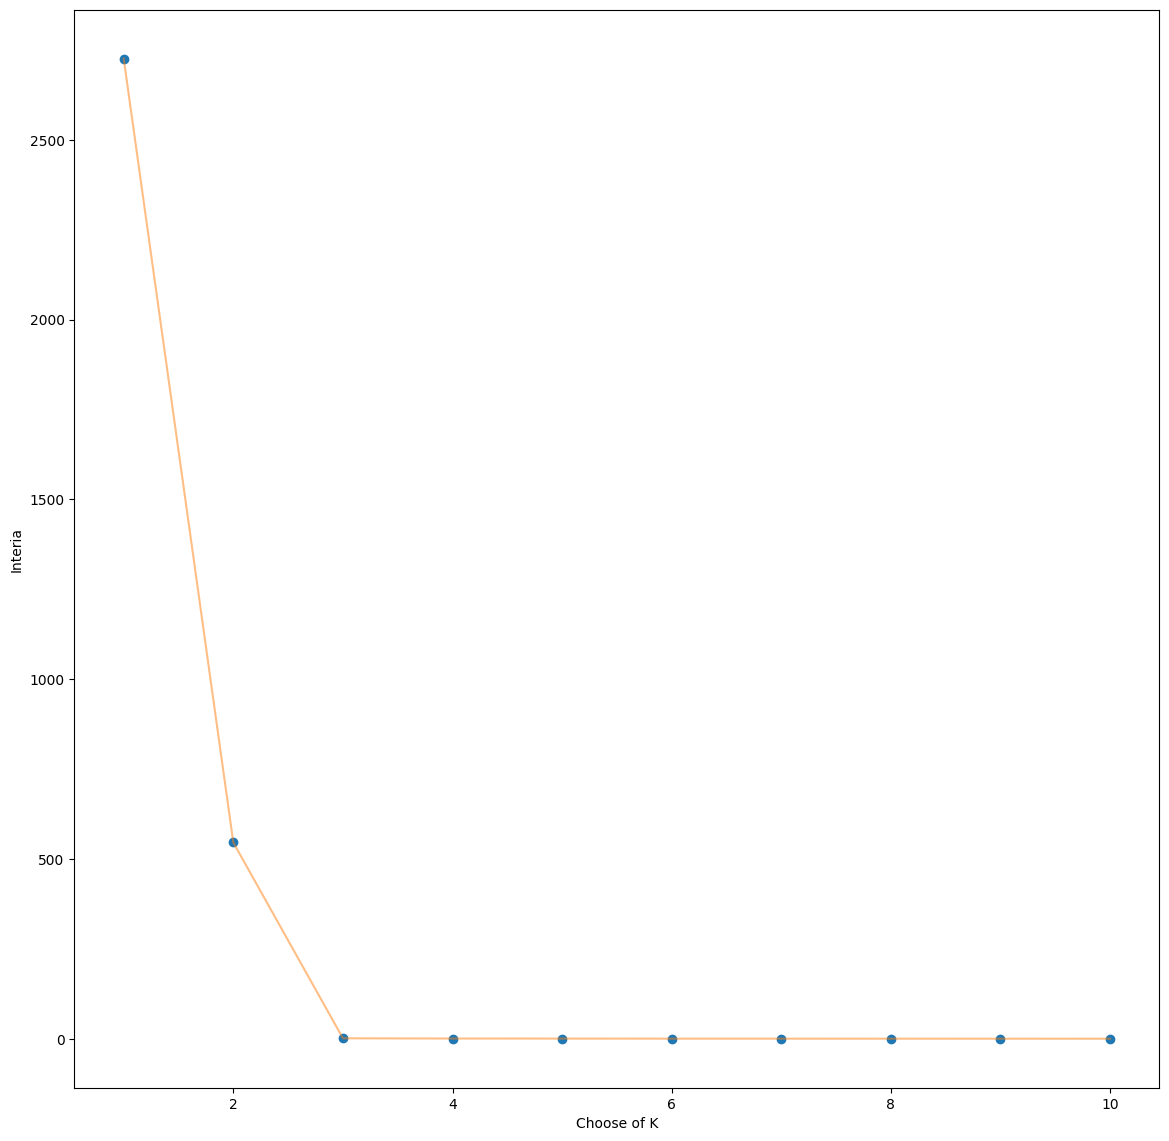

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
X = scores[index_user].detach().numpy()
df_graph = pd.DataFrame(columns=['first','second','third','label'])
df_graph['first'] = X[:,0]
df_graph['second'] = X[:,1]
df_graph['third'] = X[:,2]
df1 = df_graph[['first','second','third']].iloc[:,:].values
inertia = []

for k in range(1,11):
    algorithm = (KMeans(n_clusters=k,
                       init="k-means++",
                       n_init=10,
                       max_iter=300,
                       tol=0.0001,
                       random_state=111,
                       algorithm="full"))
    algorithm.fit(df1)
    inertia.append(algorithm.inertia_)
plt.figure(1,figsize=(15,6))
plt.plot(np.arange(1,11), inertia, 'o')
plt.plot(np.arange(1,11), inertia, '-', alpha=0.5)

plt.xlabel("Choose of K")
plt.ylabel("Interia")
plt.show()

In [16]:
n_clusters = 4
estimators = KMeans(n_clusters=n_clusters)
estimators.fit(X)
labele = estimators.labels_
df_graph['label'] = labele

/home/jinfeng/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'


Cluster: 0 0.0021302851382642984 0.002854650840163231 0.9950146079063416


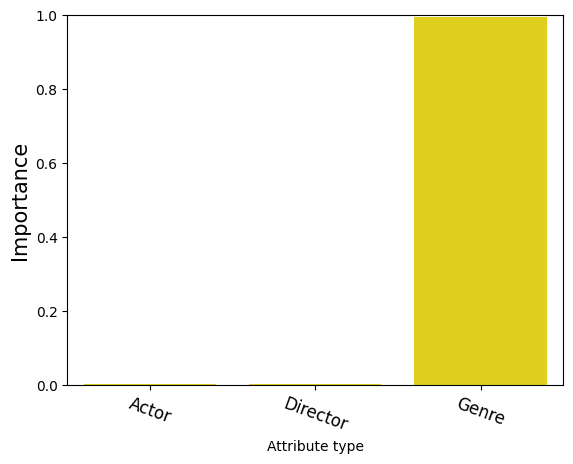

Cluster: 1 0.9982044100761414 0.0011552585056051612 0.000640972051769495


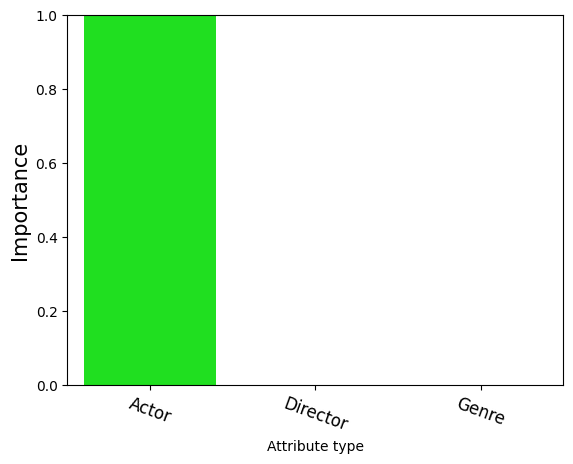

Cluster: 2 0.0026691770181059837 0.993629515171051 0.0037008512299507856


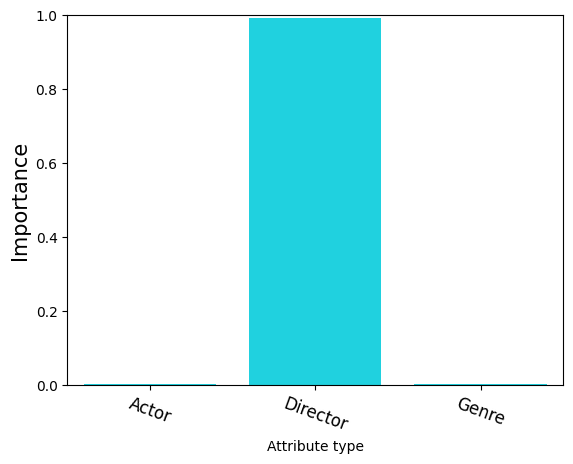

Cluster: 3 0.008118826895952225 0.6091504096984863 0.38273075222969055


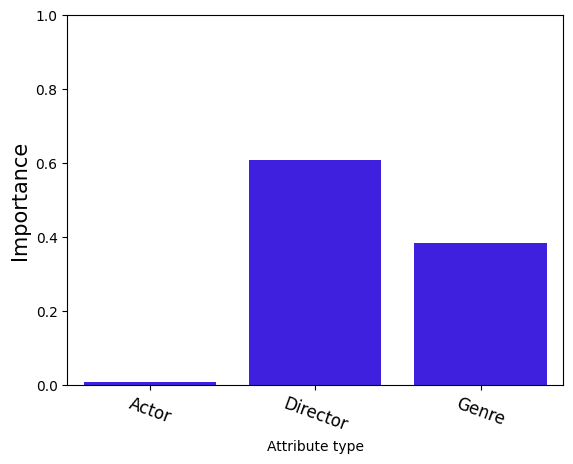

In [51]:
import seaborn as sns
style = "gist_rainbow"
colors = sns.color_palette(style, n_clusters)
for i in range(n_clusters):
    print("Cluster:", i, df_graph[df_graph['label'] == i]['first'].mean(),df_graph[df_graph['label'] == i]['second'].mean(),df_graph[df_graph['label'] == i]['third'].mean())
    import matplotlib.pyplot as plt
    plt.xlabel('Attribute type')
    plt.ylabel('Importance',fontsize=15)
    plt.ylim([0,1])
    name_list = ['Actor', 'Director','Genre']
    num_list = [df_graph[df_graph['label'] == i]['first'].mean(),df_graph[df_graph['label'] == i]['second'].mean(),df_graph[df_graph['label'] == i]['third'].mean()]

    hist_fig = sns.barplot(x = name_list, y = num_list,tick_label=name_list, color=colors[i])
    plt.xticks(fontsize  = 'large',rotation=-20)
    #plt.savefig('/home/jinfeng/Downloads/doctorant/Conférences/dsaa/argumrntative/test2.png')

    plt.show()


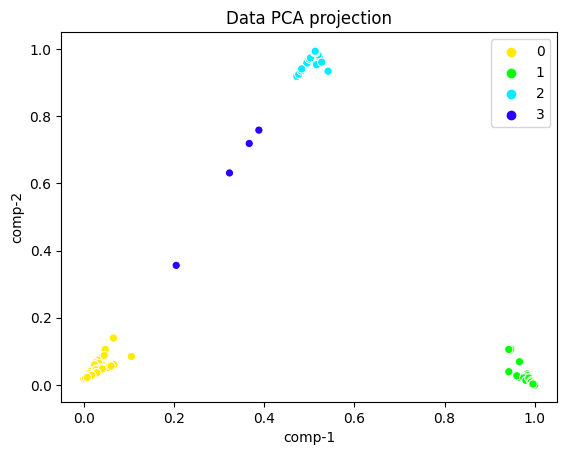

In [52]:
from sklearn.decomposition import PCA
result = PCA(n_components=2).fit_transform(X)
x_min, x_max = np.min(result, 0), np.max(result, 0)
result = (result - x_min) / (x_max - x_min)
import seaborn as sns
df = pd.DataFrame()
df["y"] = labele
df["comp-1"] = result[:,0]
df["comp-2"] = result[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette(style, n_clusters),
                data=df).set(title="Data PCA projection")
#plt.savefig('cluster_pca.png')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


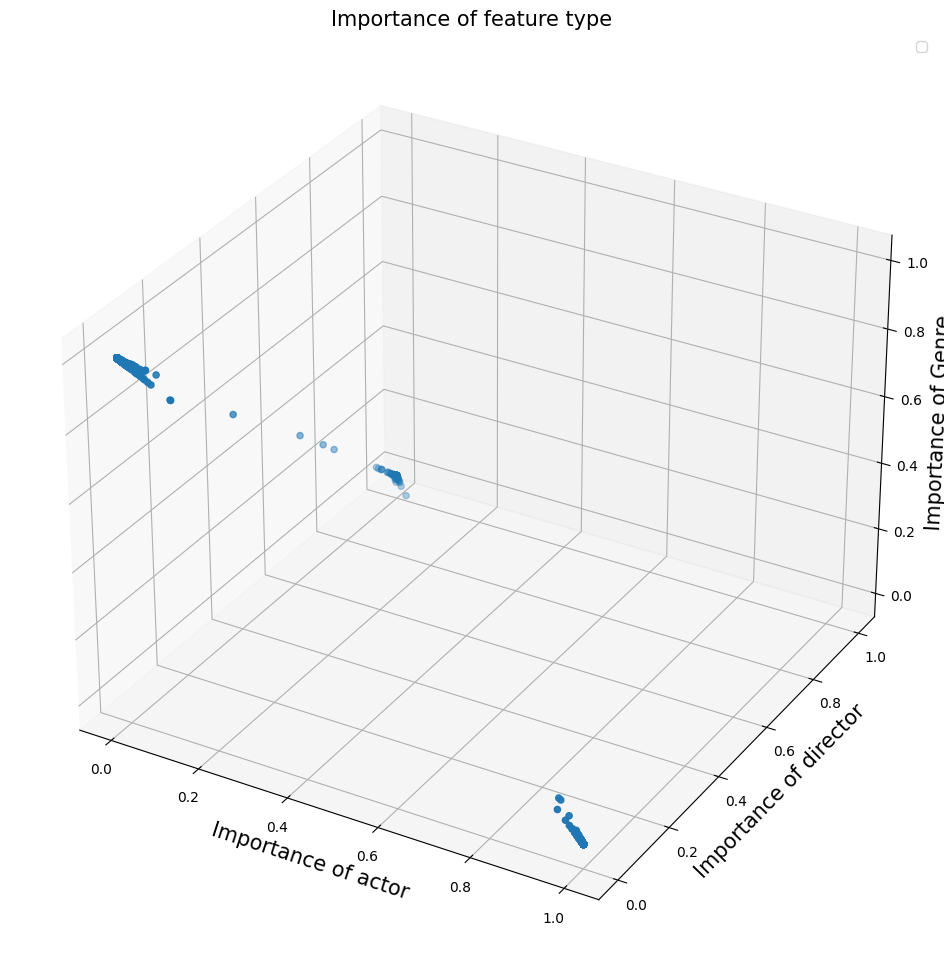

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization!
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:,0], X[:,1], X[:,2])

ax.set_title("Importance of feature type",fontsize=15)
ax.set_xlabel('Importance of actor',fontsize=15)
ax.set_ylabel('Importance of director',fontsize=15)
ax.set_zlabel('Importance of Genre',fontsize=15)

ax.legend()
plt.show()
plt.savefig('3d.png')



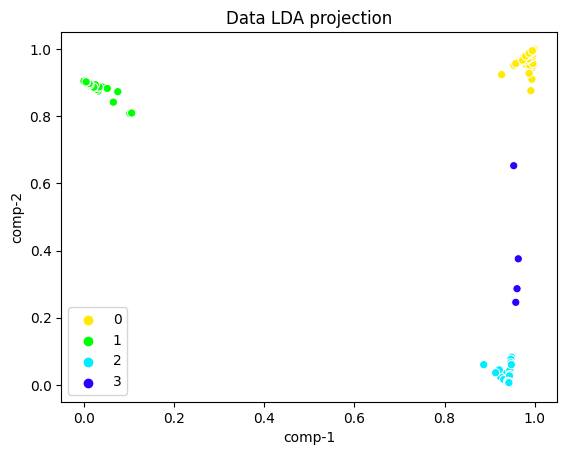

In [53]:
# Step 2: Apply Linear Discriminant Analysis to reduce dimension to 2D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X, labele)

import seaborn as sns
x_min, x_max = np.min(X_lda, 0), np.max(X_lda, 0)
X_lda = (X_lda - x_min) / (x_max - x_min)
df = pd.DataFrame()
df["y"] = labele
df["comp-1"] = X_lda[:,0]
df["comp-2"] = X_lda[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette(style, n_clusters),
                data=df).set(title="Data LDA projection")
plt.show()

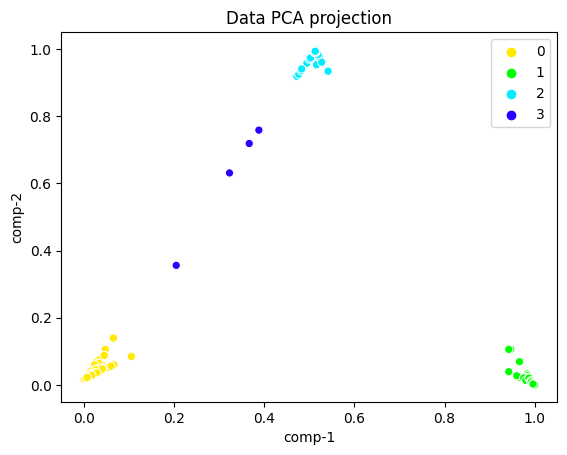

In [54]:
from sklearn.decomposition import PCA
result = PCA(n_components=2).fit_transform(X)
x_min, x_max = np.min(result, 0), np.max(result, 0)
result = (result - x_min) / (x_max - x_min)
import seaborn as sns
df = pd.DataFrame()
df["y"] = labele
df["comp-1"] = result[:,0]
df["comp-2"] = result[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette(style, n_clusters),
                data=df).set(title="Data PCA projection")
#plt.savefig('cluster_pca.png')
plt.show()


Starting compute t-SNE Embedding...


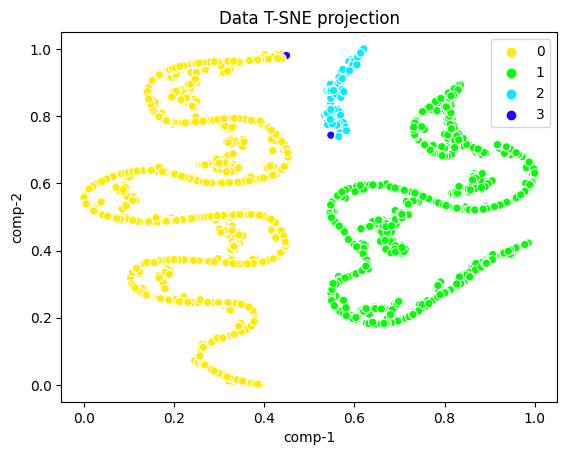

In [56]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
data, label, n_samples, n_features,title = X, labele, 38616, 3,'Cluster of users according to importances of contexts'
print('Starting compute t-SNE Embedding...')
ts = TSNE(n_components=2, init='pca', random_state=0)

result = ts.fit_transform(data)

x_min, x_max = np.min(result, 0), np.max(result, 0)
result = (result - x_min) / (x_max - x_min)
import seaborn as sns
df = pd.DataFrame()
df["y"] = labele
df["comp-1"] = result[:,0]
df["comp-2"] = result[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette(style, n_clusters),
                data=df).set(title="Data T-SNE projection")
plt.show()